# Forecasting de la Demanda Energetica en California

#### **Caso**: 
Nuestro caso principal es estudiar la demanda energética de California, cabe destacar que es el tercer estado con mayor Extensión de los Estados Unidos de América, el equivalente al 85% del territorio Español, además de ser el primer mercado de los Estados Unidos, con un PIB de 2.656.080 millones de dólares, lo que supone el 14,2% del PIB de un país, Estados Unidos, cuyo PIB representa el 24% del total mundial.

También sabemos que California es hogar de varias regiones económicas importantes como Hollywood, Valle Central de California, Tech Coast y Sillicon Valley
- Disponemos de una base de datos sobre la demanda de energergetica de California desde 1/07/2015 al 30/11/2021

El dataset que usaremos es proporcionado por nuestro tutor en formato 'xlsx' y se compone por cinco columnas.
La informacion que nos proporciona es:
- Region: En este caso california
- UTC time: Tiempo universal coordinado
- Local date: La fecha de la zona
- Local hour: La hora de la zona
- Local time: Concatenación de 'Local date' y 'Local hour'
- Time zone: La zona horaria, en este caso pacífico
- D: La demanda energética

#### **Objetivos**:

En el presente análisis desarrollaremos distintos algoritmos para predecir:
- Los 7 primeros días de diciembre de 2021 en perioricidad horaria (01/12/2021-07/12/2021) 
- Los 15 primeros días de diciembre de 2021 en perioricidad diaría (01/12/2021-15/12/2021)

En este caso nos centraremos en la periocidad `diaria`

#### Cargamos librerias

In [1]:

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.boxcox import LogTransformer
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Leemos los datos denotando la pestaña 'Daily_data'

In [2]:
df_energy = pd.read_excel('DemandaEnergia.xlsx', sheet_name='Daily Data')
df_day = df_energy.drop(['Region', 'Time zone'], axis=1)

Renombramos nuestras variables

In [3]:
df_day.rename(columns={'D': 'Demand', 'Local date': 'Local_date'}, inplace=True)
df_day.set_index('Local_date', inplace=True)

In [4]:
df_day.index = pd.PeriodIndex(df_day.index, freq='D')
df_day_complete = df_day.copy()
df_day

,Demand
Local_date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


Estudiamos nulos o duplicados

In [5]:
print("Datos duplicados: ", df_day.duplicated().sum())
print("Datos nulos por columna: \n", df_day.isnull().sum())

Datos duplicados:  7
Datos nulos por columna: 
 Demand    0
dtype: int64


Visualizamos las serie completa para estudiar si posee irregularidades

Text(0.5, 1.0, 'Demanda electrica diaria')

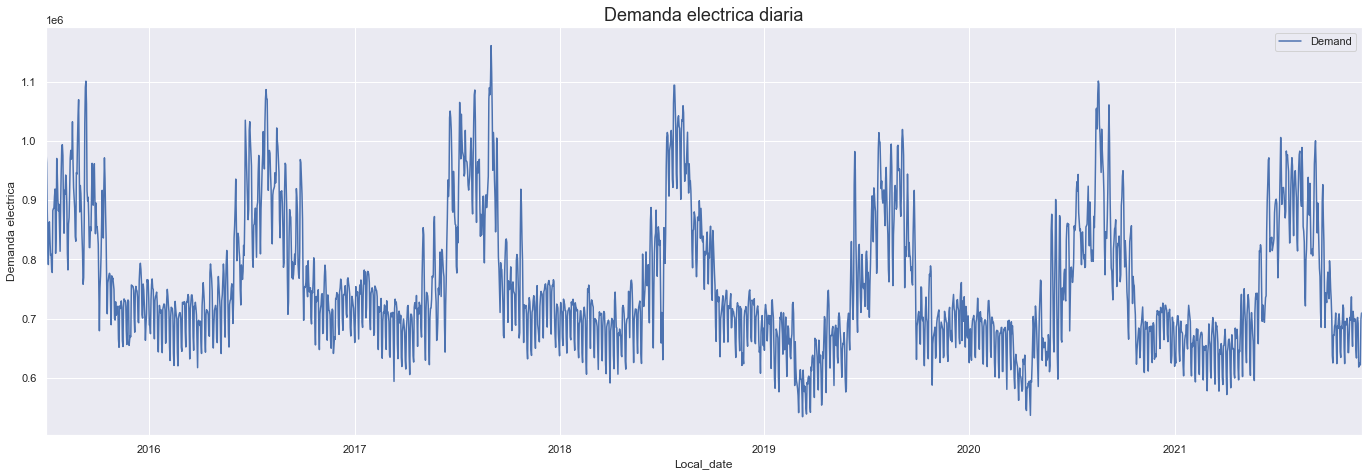

In [6]:
sns.set(rc={'figure.figsize':(21, 7)})
ax = df_day.plot(linestyle='-')
ax.set_ylabel('Demanda electrica')
ax.set_title('Demanda electrica diaria', fontsize=18)

Zoom

Creo un grafico con la serie temporal diaria y realizo un zoom de los meses de septiembre y octubre de 2021
- Observamos algunos picos de demanda de energia en septiembre, pero en especial en octubre observamos un descenso de la demanda cuanto mas nos acercamos a los fines de semana

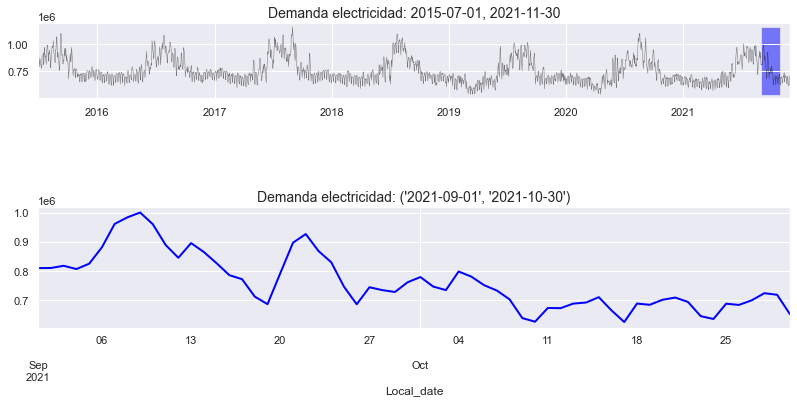

In [7]:

zoom = ('2021-09-01','2021-10-30')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

df_day.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(df_day.Demand)
max_y = max(df_day.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

df_day.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {df_day.index.min()}, {df_day.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

#### Distribucion demanda por mes
- Parece que los valores de la demanda son superiores en los meses de septiembre, agosto, julio y parte de junio, con algunos outliers significativos los meses de Noviembre, Septiembre, Junio, Mayo, no apreciamos diferencias significativas respecto al modelo horario debido a que estamos estudiando la serie mensualmente

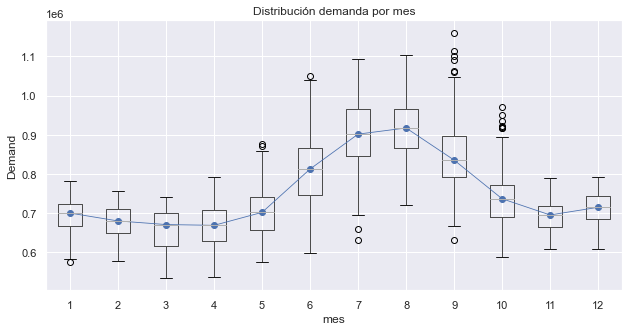

In [8]:
boxplot_month = df_day.copy()

fig, ax = plt.subplots(figsize=(10, 5))
boxplot_month['mes'] = boxplot_month.index.month
boxplot_month.boxplot(column='Demand', by='mes', ax=ax,)
boxplot_month.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

#### Distribucion demanda por dia de la semana
- Apreciamos una menor demanda cuando es fin de semana

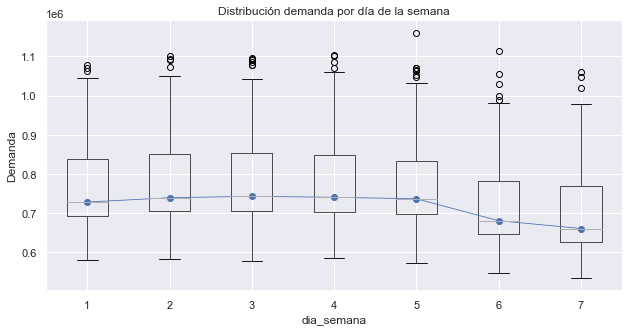

In [9]:
boxplot_week = df_day.copy()

fig, ax = plt.subplots(figsize=(10, 5))
boxplot_week['dia_semana'] = boxplot_week.index.day_of_week + 1
boxplot_week.boxplot(column='Demand', by='dia_semana', ax=ax)
boxplot_week.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');


### Estacionariedad Dicky-Fuller


In [10]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_day_complete) # Usamos el una copia del dataset con toda la información.

Results of Dickey-Fuller Test:
Test Statistic                   -3.353586
p-value                           0.012647
#Lags Used                       27.000000
Number of Observations Used    2317.000000
Critical Value (1%)              -3.433175
Critical Value (5%)              -2.862788
Critical Value (10%)             -2.567434
dtype: float64


Analizamos los resultados arrojados por el algoritmo Dickey_fuller:
- HO: No estacionaria
- H1: Estacionaria

Con p-value del 0.012
por lo que rechazamos la hipotesis nula y nuestra serie es estacionaria

### Aplicamos logaritmos COMENTAR VARIANZA

In [11]:
transformer = LogTransformer()
log_day= transformer.fit_transform(df_day)
log_day.tail()

,Demand
2021-11-26,13.345590
2021-11-27,13.342128
2021-11-28,13.340723
2021-11-29,13.457164
2021-11-30,13.472412


#### Separamos la serie en Train y Test, una sin logaritmos aplicados a nuestra serie y otra con logaritmos

Sin logaritmos:

In [12]:
df_day_loc = df_day.loc['2021-01-01':'2021-11-30']
fin_train = '2021-11-01'

train_y = df_day_loc.loc[: fin_train, :]
test_y  = df_day.loc[fin_train:, :]

print(f"Fechas train      : {train_y.index.min()} --- {train_y.index.max()}")
print(f"Fechas test       : {test_y.index.min()} --- {test_y.index.max()}")

Fechas train      : 2021-01-01 --- 2021-11-01
Fechas test       : 2021-11-01 --- 2021-11-30


Con logaritmos:

In [13]:
df_log_day = log_day.loc['2021-01-01':'2021-11-30']
fin_train = '2021-11-01'

log_train_y_day = df_log_day.loc[: fin_train, :]
log_test_y_day  = df_log_day.loc[fin_train:, :]

print(f"Fechas train      : {log_train_y_day.index.min()} --- {log_train_y_day.index.max()}")
print(f"Fechas test       : {log_test_y_day.index.min()} --- {log_test_y_day.index.max()}")

Fechas train      : 2021-01-01 --- 2021-11-01
Fechas test       : 2021-11-01 --- 2021-11-30


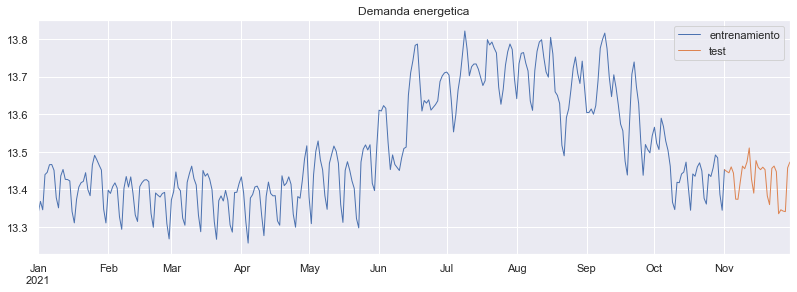

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
log_train_y_day.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
log_test_y_day.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda energetica')
ax.legend();

# ETS

Error, Trend and Seasonal
- Es un método de aproximacion para la prevision de series temporales univariantes como es nuestro caso, aquí nos centramos en los componentes de la tendencia y la estacionalidad. Este metodo posee una gran flexibilidad debido a los diferentes rasgos de sus componentes como son la:


| |  | Estacionalidad |  |
| --- | --- | --- | --- |
| **Tendencia** | N(None) | A (Additive) | M (Multiplicative)
| N (None) | NN | NA | NM
| A (Additive) | AN | AA | AM
|M (Multiplicative) | MN | MA | MM|

Todos los modelos ETS son no estacionarios por lo que en este apartado no aplicaremos los logaritmos y así, no transformamos la serie a estacionaria

Existen 15 modelos con errores aditivos y 15 modelos con errores multiplicativos, simplificando un poco la tabla anterior obtenemos menos modelos.
Existen diferentes criterios que tendremos encuenta para nuestro análisis:
    
- Criterio de información Akaike (AIC)
- ritero de informacion bayesiano (BIC)

In [15]:
# Forecast Horizon
fh = np.arange(len(test_y)) + 1 # forecasting horizon
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [16]:
fh_ETS = np.arange(len(test_y))
ETS_auto_model = AutoETS(auto=True, sp=7, n_jobs=-1)

In [17]:
# specifying the forecasting algorithm
autoETS_model = AutoETS(auto=True, sp=7, n_jobs=-1)

In [18]:
#  Auto ETS Model Estimation
autoETS_model.fit(train_y.astype('float64'))

AutoETS(auto=True, n_jobs=-1, sp=7)

In [19]:
#  Auto ETS Model Summary
print(autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  305
Model:                       ETS(MNM)   Log Likelihood               -3495.198
Date:                Fri, 21 Jan 2022   AIC                           7012.395
Time:                        14:08:12   BIC                           7053.319
Sample:                    01-01-2021   HQIC                          7028.764
                         - 11-01-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999        nan        nan        nan         nan         nan
smoothing_seasonal  1.001e-05        nan        nan        nan         nan         nan
initial_level       

In [20]:
#  Auto ETS Forecasting
ETS_pred = autoETS_model.predict(fh_ETS)
print(ETS_pred)

                   Demand
2021-11-01  685833.385344
2021-11-02  706867.348800
2021-11-03  710143.663939
2021-11-04  710165.277186
2021-11-05  703057.108091
2021-11-06  655928.661733
2021-11-07  632987.384481
2021-11-08  695420.137215
2021-11-09  706867.348800
2021-11-10  710143.663939
2021-11-11  710165.277186
2021-11-12  703057.108091
2021-11-13  655928.661733
2021-11-14  632987.384481
2021-11-15  695420.137215
2021-11-16  706867.348800
2021-11-17  710143.663939
2021-11-18  710165.277186
2021-11-19  703057.108091
2021-11-20  655928.661733
2021-11-21  632987.384481
2021-11-22  695420.137215
2021-11-23  706867.348800
2021-11-24  710143.663939
2021-11-25  710165.277186
2021-11-26  703057.108091
2021-11-27  655928.661733
2021-11-28  632987.384481
2021-11-29  695420.137215
2021-11-30  706867.348800


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

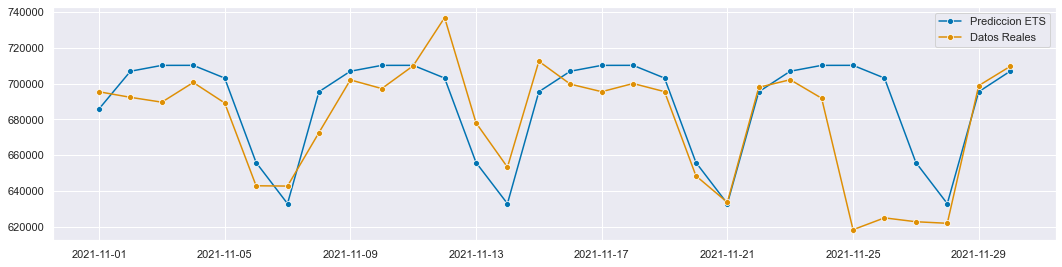

In [21]:
plot_series(ETS_pred, test_y, labels=[ "Prediccion ETS", "Datos Reales"])

### Modelo ARIMA

Este metodo es similar a una regresion estadistica pero aplicando los conceptos de las series de tiempo; por tanto, los pronosticos del modelo vienen explicados por los datos del pasado obviamente ya que no poseemos ninguna variable exógena que nos ayude a la hora de predecir, además de que somos conscientes de la estacionaridad y estacionalidad de nuestra serie a lo largo del tiempo.

El horizonte de prediccion del modelo es principalmente a corto plazo, teniendo en cuenta esto estudiaremos las predicciones que nos arroje el algoritmo.

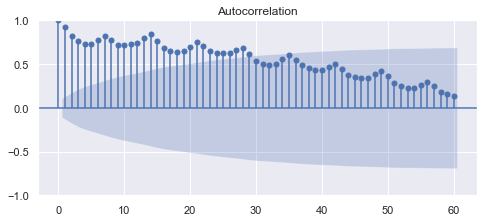

In [22]:
# Autocorrelation

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df_log_day.Demand, ax=ax, lags=60)
plt.show()

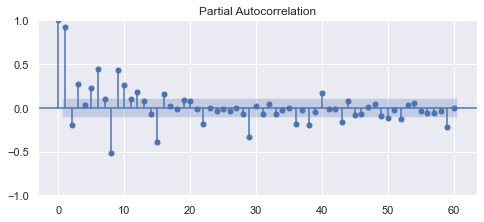

In [23]:
# Partial Autocorrelation
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df_log_day.Demand, ax=ax, lags=60)
plt.show()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

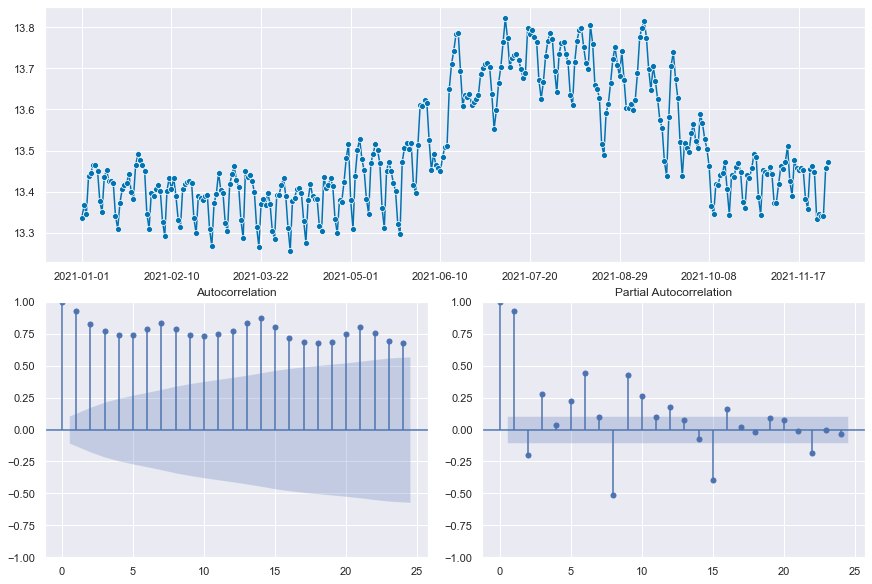

In [24]:
plot_correlations(df_log_day)

In [25]:
fh_ARIMA = np.arange(len(test_y)) + 1 

In [26]:
forecaster_ARIMA = AutoARIMA(sp=7 ,suppress_warnings=True, n_jobs=-1)
forecaster_ARIMA.fit(log_train_y_day)

AutoARIMA(n_jobs=-1, sp=7, suppress_warnings=True)

In [27]:
print(forecaster_ARIMA.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  305
Model:             SARIMAX(1, 1, 4)x(2, 0, [1, 2], 7)   Log Likelihood                 640.579
Date:                                Fri, 21 Jan 2022   AIC                          -1261.158
Time:                                        14:08:54   BIC                          -1223.988
Sample:                                             0   HQIC                         -1246.289
                                                - 305                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6123      0.144      4.258      0.000       0.330       0.894
ma.

In [28]:
#  Auto ARIMA Forecast
log_y_pred = forecaster_ARIMA.predict(fh_ARIMA)
log_y_pred.tail()

,Demand
2021-11-27,13.314411
2021-11-28,13.280450
2021-11-29,13.366460
2021-11-30,13.377977
2021-12-01,13.382541


In [29]:
# Deshacemos logaritmos
np.exp(log_y_pred).tail()

,Demand
2021-11-27,605864.155222
2021-11-28,585634.084763
2021-11-29,638233.692619
2021-11-30,645626.958543
2021-12-01,648580.139367


Comparamos el test con la prediccion

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

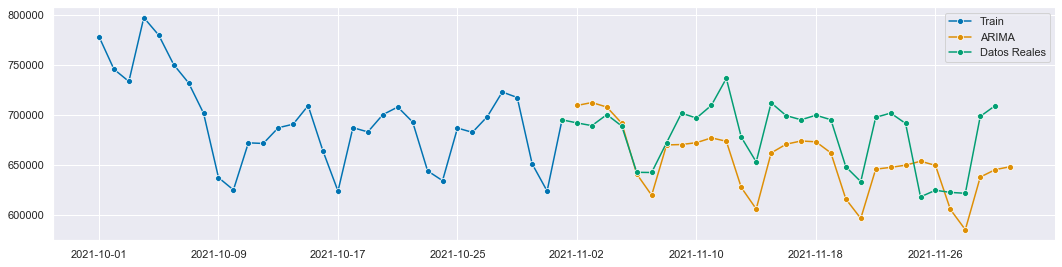

In [30]:
plot_series(train_y["2021-10":], np.exp(log_y_pred), test_y, labels=["Train", "ARIMA", "Datos Reales"])

### Calculamos los errores de la prediccion del test

In [31]:
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [32]:
def mape ( actual , pred ):
    actual, pred = np.array (actual), np.array (pred)
    return np.mean (np.abs ((actual - pred) / actual)) * 100

def mse (actual, pred):
    actual, pred = np.array (actual), np.array (pred)
    return np.square (np.subtract (actual, pred)). mean () 

rmse = MeanSquaredError(square_root=True)

Errores del modelo ETS

In [33]:
mape_ETS = mean_absolute_percentage_error(test_y, ETS_pred)
mse_ETS = mse (test_y, ETS_pred)
rmse_ETS= rmse(test_y, ETS_pred)

Errores del modelo ARIMA

In [34]:
mape_ARIMA = mean_absolute_percentage_error(log_test_y_day, log_y_pred)
mse_ARIMA = mse (log_test_y_day, log_y_pred )
rmse_ARIMA = rmse(log_test_y_day, log_y_pred )

In [35]:
dict_medidas = {'mape': [mape_ARIMA, mape_ETS], "mse" :[mse_ARIMA, mse_ETS], 
        'rmse': [rmse_ARIMA, rmse_ETS]
       }
    
errores = pd.DataFrame(dict_medidas, columns=["mape", "mse", 'rmse'], index = ["ARIMA", "ETS"])
print("-----------------------------------------------------------")
print(f'Estos son los errores obtenidos por el modelo ARiMA y ETS: ')
print("-----------------------------------------------------------")
print(errores)

-----------------------------------------------------------
Estos son los errores obtenidos por el modelo ARiMA y ETS: 
-----------------------------------------------------------
           mape           mse          rmse
ARIMA  0.003985  4.060154e-03      0.063719
ETS    0.025544  6.964401e+08  26390.151064


A diferencia del estudio horario, en este caso utilizaremos ETS frente al modelo ARIMA

# Modelo Final: ETS

In [36]:
fh_selected = np.arange(len(test_y)/2) + 30 # forecasting horizon
fh_selected

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44.])

In [37]:
ETS_auto_model = AutoETS(auto=True, sp=7, n_jobs=-1)
autoETS_model = AutoETS(auto=True, sp=7, n_jobs=-1)

In [38]:
# specifying the forecasting algorithm
ETS_selected = AutoETS(auto=True, sp=7, n_jobs=-1)

In [39]:
ETS_selected.fit(train_y.astype('float64'))

AutoETS(auto=True, n_jobs=-1, sp=7)

In [40]:
#  Auto ETS Model Summary
print(ETS_selected.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  305
Model:                       ETS(MNM)   Log Likelihood               -3495.198
Date:                Fri, 21 Jan 2022   AIC                           7012.395
Time:                        14:08:56   BIC                           7053.319
Sample:                    01-01-2021   HQIC                          7028.764
                         - 11-01-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999        nan        nan        nan         nan         nan
smoothing_seasonal  1.001e-05        nan        nan        nan         nan         nan
initial_level       

In [41]:
#  Auto ETS Forecasting
ETS_selected = ETS_selected.predict(fh_selected)
print(ETS_selected)

                   Demand
2021-12-01  710143.663939
2021-12-02  710165.277186
2021-12-03  703057.108091
2021-12-04  655928.661733
2021-12-05  632987.384481
2021-12-06  695420.137215
2021-12-07  706867.348800
2021-12-08  710143.663939
2021-12-09  710165.277186
2021-12-10  703057.108091
2021-12-11  655928.661733
2021-12-12  632987.384481
2021-12-13  695420.137215
2021-12-14  706867.348800
2021-12-15  710143.663939


In [42]:
df = pd.DataFrame(ETS_selected) 
df.to_csv('pred_ETS_diaria.csv')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

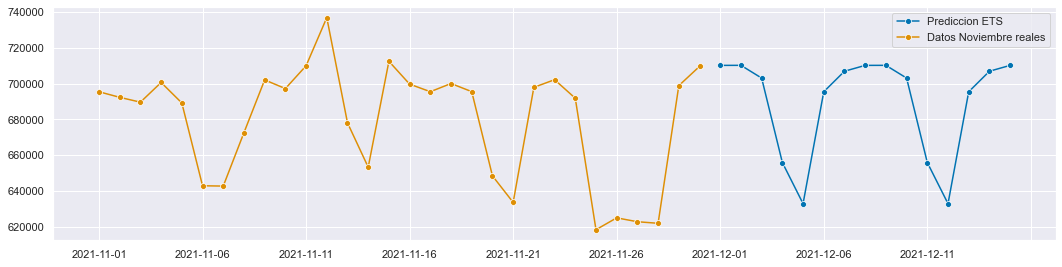

In [43]:
plot_series(ETS_selected, test_y , labels=[ "Prediccion ETS", "Datos Noviembre reales"])